# EX2.4


Design and train a neural network to approximate the following function:

```
y = x1^2 + x^2
```

where x1 and x2 are scalar inputs, and y is the output.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from types import SimpleNamespace
%matplotlib inline

In [2]:
### A) Create data sets

In [3]:
### A.1) Create a training dataset
X1 = np.arange(-22, 23, 2) 
X2 = np.arange(-10, 11, 1) 
X1, X2 = np.meshgrid(X1, X2)
y = X1**2 + X2**2
print(X1.size, X2.size)
# print(np.concatenate(X1,X2))

483 483


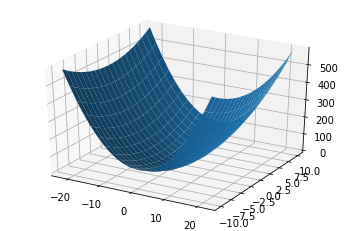

In [4]:
# Plot the training set

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter 
import numpy as np 
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface. 
surf = ax.plot_surface(X1, X2, y) 
plt.show()


In [5]:
### A.2) Create the first testing dataset (Test1)
Test1X1 = np.arange(-22, 22, 0.88) 
Test1X2 = np.arange(-10, 10, 0.4) 
Test1X1, Test1X2 = np.meshgrid(Test1X1, Test1X2)
Test1y = Test1X1**2 + Test1X2**2

In [6]:
### A.3) Create the second testing dataset (Test2)
Test2X1 = np.arange(-50, 50, 2) 
Test2X2 = np.arange(-30, 30, 1.2) 
Test2X1, Test2X2 = np.meshgrid(Test2X1, Test2X2)
Test2y = Test2X1**2 + Test2X2**2

In [7]:
# Normalize data
def normalize(train, test1, test2):
    train_bar = np.reshape(train, [-1, 1])
    std_data= np.std(train_bar, 0)
    mean_data= np.mean(train_bar, 0)

    train = (train-mean_data)/std_data
    test1 = (test1-mean_data)/std_data
    test2 = (test2-mean_data)/std_data
    return train, test1, test2, std_data, mean_data

# Method to denormalize data (for plotting)
def denormalize(data, std_data, mean_data):
    return (data * std_data) + mean_data

X1, Test1X1, Test2X1, stdX1, meanX1 = normalize(X1, Test1X1, Test2X1)
X2, Test1X2, Test2X2, stdX2, meanX2 = normalize(X2, Test1X2, Test2X2)
y,  Test1y,  Test2y,  stdy,  meany  =  normalize(y,  Test1y,  Test2y)

In [14]:
### B) Train a neural network using TensorFlow.
def train(hidden_layer_activation_function):
    input_size = 2
    n_hidden = 25
    n_outputs = 1

    sess = tf.InteractiveSession()
    w1 = tf.Variable(
        tf.truncated_normal(
            shape=[input_size, n_hidden],
            stddev=0.1), 
        name= 'w1')
    b1 = tf.Variable(
        tf.truncated_normal(
            shape=[n_hidden], 
            stddev=0.1), 
        name= 'b1')

    w2 = tf.Variable(
        tf.truncated_normal(
            shape=[n_hidden, n_outputs],
            stddev=0.1), 
        name= 'w2')
    b2 = tf.Variable(
        tf.truncated_normal(
            shape=[n_outputs], 
            stddev=0.1), 
        name= 'b2')

    # Define train setup
    inputs = tf.placeholder(tf.float32, [None, input_size])
    labels = tf.placeholder(tf.float32, [None, n_outputs])

    h1 = hidden_layer_activation_function(tf.matmul(inputs, w1) + b1)

    # Output layer.
    yp = tf.matmul(h1, w2) + b2

    # Optimizer.
    loss = tf.reduce_mean((yp - labels)**2)
    optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss) 

    def error(predictions, labels):
            return np.sum((predictions - labels)**2)/ predictions.shape[0]


    num_steps = 10000
    summary_freq = 1000
    n_test_logg = 10 # number of evaluations on test dataset (for logging information)

    tf.global_variables_initializer().run()
    print('Initialized')

    # lists for plotting
    l_epoch = []
    l_train_error = []
    l_test1_error = []
    l_test2_error = []

    mean_loss= 0
    train_error = 0
    # Perform num_steps training steps
    for step in range(num_steps):
        batch_X, batch_y= np.concatenate((np.reshape(X1, [-1,1]), np.reshape(X2, [-1,1])), axis=1), np.reshape(y, [-1,1])
        feed_dict = {inputs : batch_X, labels : batch_y}
        _, l, train_pred = sess.run([optimizer, loss, yp],feed_dict=feed_dict)

        train_error += error(train_pred, batch_y)
        mean_loss += l    
        if step%summary_freq == 0:
            # Obtain train error
            train_error = train_error/summary_freq
            # Evaluate error on test dataset
            test_error1 = 0
            test_error2 = 0
            for i in range(n_test_logg):
                # Test1
                batch_X_test, batch_y_test = np.concatenate((np.reshape(Test1X1, [-1,1]), np.reshape(Test1X2, [-1,1])), axis=1), np.reshape(Test1y, [-1,1])
                pred = yp.eval(feed_dict={inputs: batch_X_test})
                test_error1 += error(pred, batch_y_test)

                # Test2
                batch_X_test, batch_y_test = np.concatenate((np.reshape(Test2X1, [-1,1]), np.reshape(Test2X2, [-1,1])), axis=1), np.reshape(Test2y, [-1,1])
                pred = yp.eval(feed_dict={inputs: batch_X_test})
                test_error2 += error(pred, batch_y_test)
            test_error1= test_error1/n_test_logg
            test_error2=test_error2/n_test_logg

            l_epoch.append(step)
            l_train_error.append(train_error)
            l_test1_error.append(test_error1)
            l_test2_error.append(test_error2)

            print(step, ', train:',train_error,' | test1:', test_error1, ' | test2:', test_error2, ' | loss:', mean_loss/summary_freq)
            mean_loss= 0
            train_error= 0
            
    # Plot each type:
    plot(X1, X2, y, yp, inputs, title="Train")
    plot(Test1X1, Test1X2, Test1y, yp, inputs, title="Test1")
    plot(Test2X1, Test2X2, Test2y, yp, inputs, title="Test2")
            
def plot(X1, X2, y, yp, inputs, title="", show_real_values=False):
    # Plot outputs for Test2
    batch_X_test, batch_y_test= np.concatenate((np.reshape(X1, [-1,1]), np.reshape(X2, [-1,1])), axis=1), np.reshape(y, [-1,1])
    pred = yp.eval(feed_dict={inputs: batch_X_test})

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface. 
    X_surf = denormalize(X1, stdX1, meanX1) 
    Z_surf = denormalize(X2, stdX2, meanX2) 
    Y_surf_pred = denormalize(np.reshape(pred, y.shape), stdy, meany)
    Y_surf_real = denormalize(y, stdy, meany)
    surf1 = ax.plot_surface(X_surf, Z_surf, Y_surf_pred, label="Prediction")

    if show_real_values:
        surf2 = ax.plot_surface(X_surf, Z_surf, Y_surf_real, label="Real Value")

        # Some strange bug
        surf1._facecolors2d=surf._facecolors3d
        surf1._edgecolors2d=surf._edgecolors3d
        surf2._facecolors2d=surf._facecolors3d
        surf2._edgecolors2d=surf._edgecolors3d
        # End bug code

        plt.legend()
    if title:
        plt.title(title)
    plt.show()

Initialized
0 , train: 0.0010431633138983719  | test1: 0.8542798700896006  | test2: 59.807368700817506  | loss: 0.0010431632995605469
1000 , train: 0.7106209179144732  | test1: 0.0773716264162826  | test2: 39.42230467705385  | loss: 0.7106209125444293
2000 , train: 0.042115291370401625  | test1: 0.012166901070772338  | test2: 28.239745936531243  | loss: 0.042115289567038416
3000 , train: 0.010113265728559622  | test1: 0.004817397657547247  | test2: 22.48886772383108  | loss: 0.010113264840561896
4000 , train: 0.004181032167937142  | test1: 0.002002367606551378  | test2: 18.39584849987011  | loss: 0.004181031581712887
5000 , train: 0.0016762977586307279  | test1: 0.0006964121815281123  | test2: 15.267793994011068  | loss: 0.001676297402649652
6000 , train: 0.0005044885484174606  | test1: 0.0001481783384292212  | test2: 13.07082149547173  | loss: 0.0005044883635855513
7000 , train: 0.00012460020612182061  | test1: 6.135660409008714e-05  | test2: 11.799898162548534  | loss: 0.000124600136

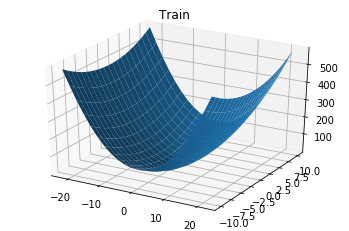

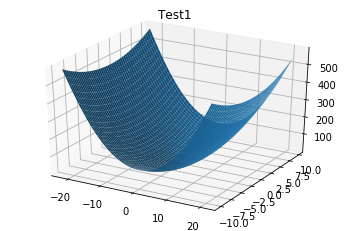

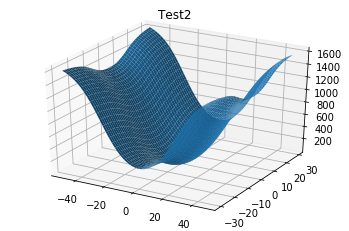

In [19]:
### B.1) Using Sigmoid
train(hidden_layer_activation_function=tf.nn.sigmoid)

Initialized
0 , train: 0.0010225170581270265  | test1: 0.9058368760502191  | test2: 56.7817956098542  | loss: 0.0010225170850753785
1000 , train: 0.22886320489106357  | test1: 0.005281084681198616  | test2: 14.425450185479608  | loss: 0.22886320344591513
2000 , train: 0.003296357154450024  | test1: 0.0018271517159361762  | test2: 10.698745091768199  | loss: 0.0032963567515835166
3000 , train: 0.001856225905762814  | test1: 0.0016139511119358497  | test2: 9.835429705924446  | loss: 0.0018562257600715385
4000 , train: 0.0016277814669434013  | test1: 0.0014512833087996393  | test2: 9.414882128470895  | loss: 0.0016277813527267426
5000 , train: 0.001447077807710756  | test1: 0.001272370533965557  | test2: 9.096756917403722  | loss: 0.0014470776974922046
6000 , train: 0.0011744680071162175  | test1: 0.0008595557161209125  | test2: 8.542215790437822  | loss: 0.0011744679086259566
7000 , train: 0.0008025198952151344  | test1: 0.0006769528395725197  | test2: 8.326275712301852  | loss: 0.000802

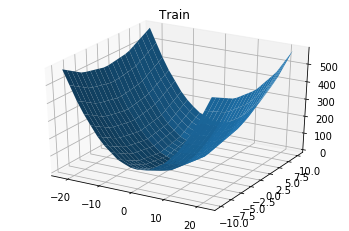

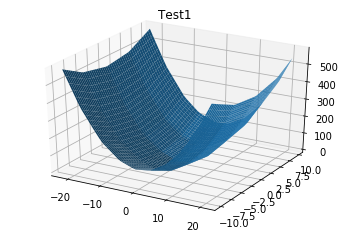

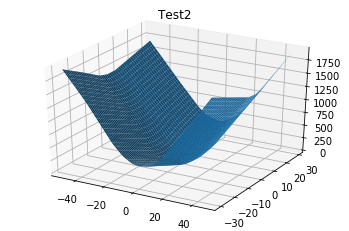

In [16]:
### B.2) Using ReLu
train(hidden_layer_activation_function=tf.nn.relu)